In [1]:
from scipy.io import arff
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pyplot as plt
import time

arff_file_path = './Rice_Cammeo_Osmancik.arff'

data, meta = arff.loadarff(arff_file_path)      # loading the data

df = pd.DataFrame(data)                         # put the data into data frame

df = df.sample(frac=1).reset_index(drop=True)   # shuffle the data

features = df.drop("Class", axis=1)             # extract features
label = df["Class"]                             # extract label

X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.16, random_state=42) # split into training and test set

# normalize(using min-max normalization) both training and test set based on the training set max and min values
min_vals = X_train.min()
max_vals = X_train.max()
column_to_be_normalized = ['Area', 'Perimeter','Major_Axis_Length','Minor_Axis_Length','Convex_Area']

for col in X_train:
    if col in column_to_be_normalized:
        X_train[col] = (X_train[col] - min_vals[col]) / (max_vals[col] - min_vals[col])
        X_test[col] = (X_test[col] - min_vals[col]) / (max_vals[col] - min_vals[col])        

In [2]:
# logistic regression with gradient descent

class LogisticRegressionGD:
    def __init__(self, data, labels,learning_rate, regularized = False, reg_param = 0):
        self.weights = np.random.rand(data.shape[1])
        self.data = data
        self.labels = labels
        self.learning_rate = learning_rate
        self.N = len(data)
        self.error_data = list()
        self.threshold = 0.0004
        self.regularized = regularized
        self.reg_param = reg_param

    def fit(self):
        prev_weights = None

        # apply gradient descent until no improvement on error func
        while not self.termination_condition(self.weights,prev_weights):
            prev_weights = self.weights + np.zeros(self.weights.shape[0])   # avoid pass by reference
            self.predict()
            self.error_data.append(self.calculate_error(self.weights))
            
            
        return self.weights

    
    def calculate_error(self,weights):
        total_sum = 0
        for i in range(self.N):
            total_sum = total_sum + np.log(1 + np.exp(-self.labels[i]*(weights @ self.data[i])))
        total_sum =  (1/self.N)*total_sum

        # regularization
        if self.regularized == True:
            total_sum += self.reg_param * (self.weights @ self.weights)

        return total_sum

    def termination_condition(self,curr_weights, prev_weights = None):
           if (prev_weights is not None) and abs(self.calculate_error(curr_weights) - self.calculate_error(prev_weights))<self.threshold:
                return True
           return False
    
    # compute gradient and take a step to the opposite direction and update weights accordingly
    def predict(self):
        gradient = 0
        for i in range(self.N):
            gradient = gradient + (self.labels[i]*self.data[i])/(1 + np.exp(self.labels[i]*(self.weights @ self.data[i])))
        gradient =  (-1/self.N)*gradient

        # derivative comes from regularization term
        if self.reg_param == True:
            gradient += 2 * self.reg_param * self.weights

        direction = -gradient
        self.weights = self.weights + self.learning_rate*direction

In [3]:
# logistic regression with stochastic gradient descent

class LogisticRegressionSGD:
    def __init__(self, data, labels,learning_rate, epoch = 1000, regularized = False, reg_param = 0):
        self.weights = np.random.rand(data.shape[1])
        self.data = data
        self.labels = labels
        self.learning_rate = learning_rate
        self.N = len(data)
        self.threshold = 0.0004
        self.error_data = list()
        self.epoch = epoch
        self.regularized = regularized
        self.reg_param = reg_param

    def fit(self):
        prev_weights = None
        for _ in range(self.epoch):
            random_index = None
            for round_count in range(self.N):
                random_index = np.random.randint(0, self.N)
                prev_weights = self.weights + np.zeros(self.weights.shape[0])
                gradient_norm = self.predict(random_index)
                random_index = np.random.randint(0, self.N)
                if random_index is not None and gradient_norm < 1e-4:
                    return self.weights
            self.error_data.append(self.calculate_error(self.weights,random_index))
            
        return self.weights
                    
    def calculate_error(self,weights,random_index):
        error = np.log(1 + np.exp(-self.labels[random_index]*(weights @ self.data[random_index])))
        # regularization
        if self.regularized == True:
            error += self.reg_param * (self.weights @ self.weights)
        return error
        
    def termination_condition(self,curr_weights,prev_weights,random_index):
           if (prev_weights is not None) and abs(self.calculate_error(curr_weights,random_index) - self.calculate_error(prev_weights,random_index))<self.threshold:
                return True
           return False
           
           
    def predict(self,random_index):
        direction = (self.labels[random_index]*self.data[random_index])/(1 + np.exp(self.labels[random_index]*(self.weights @ self.data[random_index])))
        # derivative comes from regularization term
        if self.reg_param == True:
            direction -= 2 * self.reg_param * self.weights

        self.weights = self.weights + self.learning_rate*direction
        return np.linalg.norm(-1 * direction)
        

In [4]:
def validate(test_data, test_labels, weights):
    corrects = 0
    for i in range(len(test_data)):
        s = weights @ test_data[i]
        output = 1 / (1 + np.exp(-s))

        if (output > 0.5 and test_labels[i] == 1) or (output < 0.5 and test_labels[i] == -1):
            corrects += 1
            
    acc = corrects / len(test_data)
    return acc

In [5]:
def cross_validation():
    tranformed_y_train = np.array([-1 if x == b'Cammeo' else 1 for x in y_train.values])

    kf = KFold(n_splits=5)

    lambdas = [0.05, 0.1, 0.5, 1, 5]

    lambda_train_accuracies = []

    lambda_val_accuracies = []

    for cross in range(5):
        reg_param = lambdas[cross] 
        print(f"chosen lambda : {reg_param}")
        lambda_train_acc = 0
        lambda_val_acc = 0
        for train_index, val_index in kf.split(X_train):
            # Split the data into training and validation sets
            X_cross_train, X_val = X_train.values[train_index], X_train.values[val_index]
            y_cross_train, y_val = tranformed_y_train[train_index], tranformed_y_train[val_index]

            logistic_regression = LogisticRegressionGD(X_cross_train, y_cross_train, 0.05, regularized=True, reg_param=reg_param)
            learned_weights = logistic_regression.fit()

            lambda_train_acc += validate(X_cross_train, y_cross_train, learned_weights) * (1 / len(lambdas))

            lambda_val_acc += validate(X_val, y_val, learned_weights) * (1 / len(lambdas))

        lambda_train_accuracies.append(lambda_train_acc)
        lambda_val_accuracies.append(lambda_val_acc)

    print(lambdas)
    print(lambda_train_accuracies)
    print(lambda_val_accuracies)

cross_validation()


chosen lambda : 0.05
chosen lambda : 0.1
chosen lambda : 0.5
chosen lambda : 1
chosen lambda : 5
[0.05, 0.1, 0.5, 1, 5]
[0.8720312500000001, 0.8688281250000001, 0.87546875, 0.5815625, 0.869375]
[0.8671875, 0.8687499999999999, 0.8731250000000002, 0.5815625, 0.8684375000000001]


Elapsed time: 5.77390674999333 seconds
0.875625
0.8672131147540983


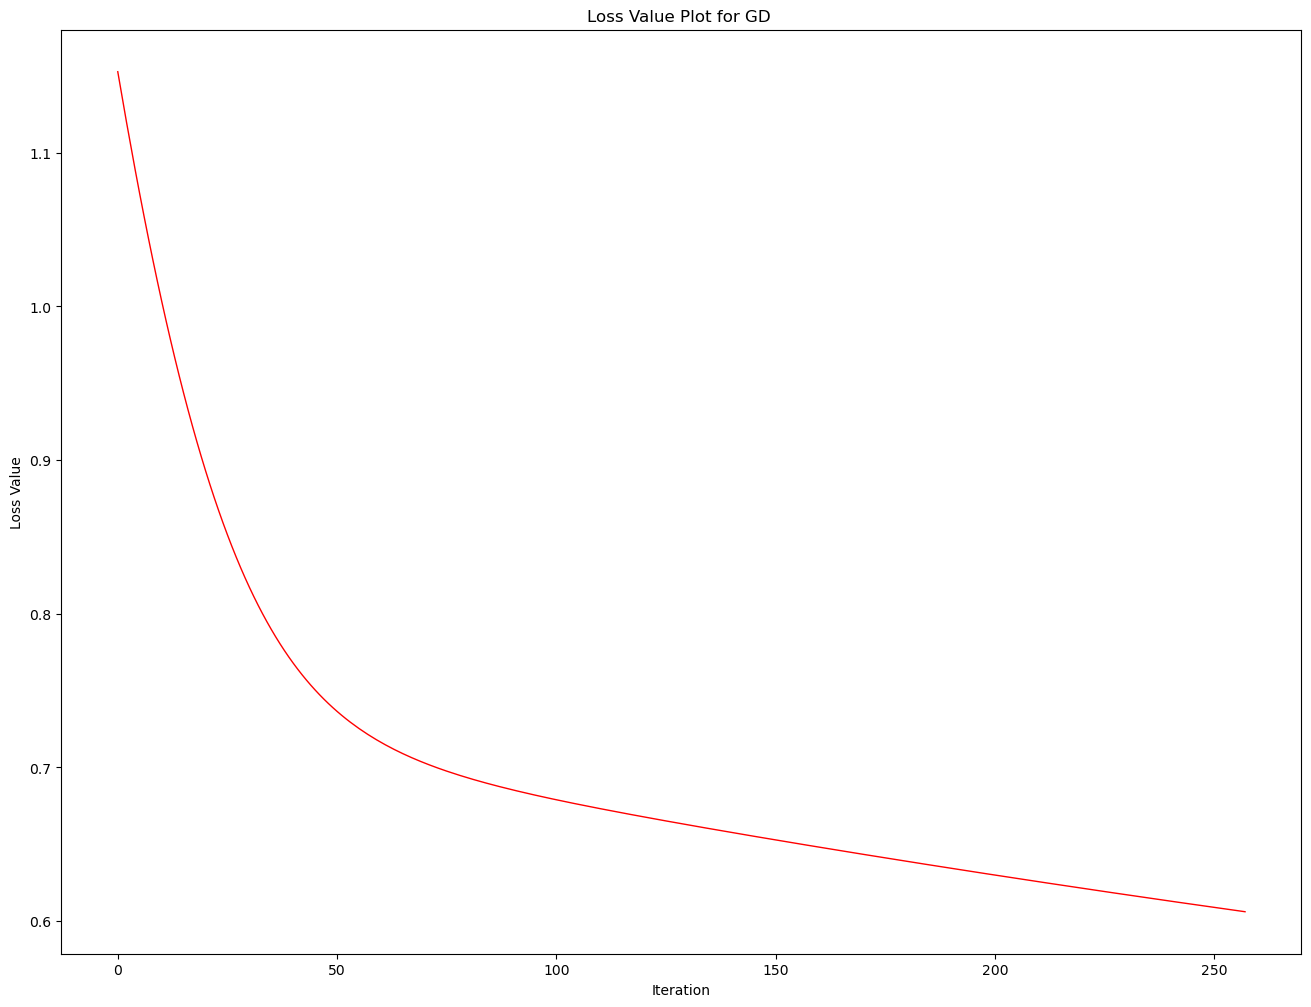

In [6]:
def model_performance():
    tranformed_y_train = np.array([-1 if x == b'Cammeo' else 1 for x in y_train.values])

    tranformed_y_test = np.array([-1 if x == b'Cammeo' else 1 for x in y_test.values])

    logistic_regression = LogisticRegressionGD(X_train.values, tranformed_y_train, 0.05, regularized = False)
    start_time = time.perf_counter()
    learned_weights = logistic_regression.fit()
    end_time = time.perf_counter()

    print("Elapsed time:", end_time - start_time,"seconds")

    train_acc = validate(X_train.values, tranformed_y_train, learned_weights)

    test_acc = validate(X_test.values, tranformed_y_test, learned_weights)


    print(train_acc)
    print(test_acc)


    errors = logistic_regression.error_data
    plt.figure(figsize=(16, 12))
    plt.plot(range(len(errors)), errors, color='red', linestyle='-', linewidth=1, label='Straight line')
    plt.xlabel('Iteration')
    plt.ylabel('Loss Value')
    plt.title('Loss Value Plot for GD ')
    plt.savefig('loss-value-gd.png')


model_performance()